# few-shot classification model with TensorFlow Lite


In [ ]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 31.5 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow-addons
!git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow && pip install -e .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.8 MB/s eta 0:00:00
Cloning into 'onnx-tensorflow'...
remote: Enumerating objects: 6516, done.
remote: Counting objects: 100% (465/465), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 6516 (delta 326), reused 383 (delta 261), pack-reused 6051
Receiving objects: 100% (6516/6516), 1.98 MiB | 6.44 MiB/s, done.
Resolving deltas: 100% (5051/5051), done.
Obtaining file:///content/onnx-tensorflow
  Preparing metadata (setup.py) ... done
  Running setup.py develop for onnx-tf


In [ ]:
!pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 708.0 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm
import os
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

Now, we need a dataset.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to your dataset
MOUNT_PATH="/content/drive/MyDrive/FYP Works Pvt/CustomYogaPosesDatasetKeypoints"
train_dataset_path = f"{MOUNT_PATH}/train"
test_dataset_path = f"{MOUNT_PATH}/test"
visualize_dataset_path = f"{MOUNT_PATH}/visualize/train"

In [ ]:
import csv

In [ ]:
import numpy as np

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        print("classes: ", self.classes)
        self.samples = []

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_path):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(class_path, file_name)
                    self.read_csv_file(file_path, label)

    def read_csv_file(self, file_path, label):
        with open(file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file)
            next(csv_reader)
            for row in csv_reader:
                data_str = row[0]
                # Remove the extra spaces and newlines and split the string into individual values
                data_str = data_str.replace('\n', '').replace('[', '').replace(']', '').split()
                # print('data_str:', data_str)
                # Convert the string values to float
                data_float = [float(value) for value in data_str]

                # Reshape the list into a NumPy array of shape (17, 3)
                # feature_vector = np.array(data_float).reshape((17, 3))
                self.samples.append((data_float, label))

    def __getitem__(self, index):
        keypoints, label = self.samples[index]

        # Convert the NumPy array to a PyTorch tensor
        keypoints_tensor = torch.tensor(keypoints, dtype=torch.float32)

        return keypoints_tensor, label

    def __len__(self):
        return len(self.samples)


In [ ]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        print("classes: ", self.classes)
        self.samples = []

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_path):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(class_path, file_name)
                    self.read_csv_file(file_path, label)

    def read_csv_file(self, file_path, label):
        with open(file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file)
            next(csv_reader)
            for row in csv_reader:
                data_str = row[0]
                # Remove the extra spaces and newlines and split the string into individual values
                data_str = data_str.replace('\n', '').replace('[', '').replace(']', '').split()
                # print('data_str:', data_str)
                # Convert the string values to float
                data_float = [float(value) for value in data_str]
                # print('data_float:', data_float)

                # Reshape the list into a NumPy array of shape (17, 3)
                # feature_vector = np.array(data_float).reshape((17, 3))
                # print('feature_vector:', feature_vector)
                self.samples.append((data_float, label))

    def __getitem__(self, index):
        keypoints, label = self.samples[index]

        # Convert the NumPy array to a PyTorch tensor
        keypoints_tensor = torch.tensor(keypoints, dtype=torch.float32)

        return keypoints_tensor, label

    def __len__(self):
        return len(self.samples)


In [ ]:
visualize_dataset = TrainDataset(root_dir=visualize_dataset_path)

classes:  ['Bow', 'Bridge', 'Camel', 'Cat', 'Cow', 'Crow', 'Extended Hand to Toe', 'Extended Side Angle', 'Forward Bend with Shoulder Opener', 'Half-Moon', 'Low Lunge', 'Plank', 'Shoulder Stand', 'Side Plank', 'Sphinx', 'Upward-Facing Dog', 'Warrior One', 'Warrior Three', 'Warrior Two', 'Wheel']


In [ ]:
train_dataset = TrainDataset(root_dir=train_dataset_path)

classes:  ['Bridge', 'Camel', 'Cat', 'Crow', 'Extended Side Angle', 'Forward Bend with Shoulder Opener', 'Half-Moon', 'Low Lunge', 'Plank', 'Shoulder Stand', 'Sphinx', 'Upward-Facing Dog', 'Warrior One', 'Warrior Three', 'Warrior Two']


In [ ]:
train_dataset.classes

['Bridge',
 'Camel',
 'Cat',
 'Crow',
 'Extended Side Angle',
 'Forward Bend with Shoulder Opener',
 'Half-Moon',
 'Low Lunge',
 'Plank',
 'Shoulder Stand',
 'Sphinx',
 'Upward-Facing Dog',
 'Warrior One',
 'Warrior Three',
 'Warrior Two']

In [ ]:
test_dataset = TestDataset(root_dir=test_dataset_path)

classes:  ['Bow', 'Cow', 'Extended Hand to Toe', 'Side Plank', 'Wheel']


In [ ]:
test_dataset.classes

['Bow', 'Cow', 'Extended Hand to Toe', 'Side Plank', 'Wheel']

In [ ]:
test_dataset.samples

[([0.2241621,
   0.03010628,
   0.7814476,
   0.19443731,
   0.05718879,
   0.86899114,
   0.19345157,
   0.05273353,
   0.87974423,
   0.2602941,
   0.12596028,
   0.8546256,
   0.25529218,
   0.12627013,
   0.80938655,
   0.3991398,
   0.19108418,
   0.78020257,
   0.36528268,
   0.20091577,
   0.7393135,
   0.4109337,
   0.50716376,
   0.4253551,
   0.39497584,
   0.49441192,
   0.9525,
   0.38054755,
   0.7668301,
   0.4646941,
   0.3588129,
   0.7552131,
   0.50213623,
   0.72724414,
   0.45279193,
   0.8726284,
   0.69760174,
   0.44733655,
   0.8469223,
   0.73350596,
   0.90598005,
   0.88837755,
   0.66101056,
   0.853419,
   0.51949954,
   0.3534798,
   0.82277197,
   0.46354738,
   0.35028547,
   0.8056431,
   0.34552145],
  0),
 ([0.24828367,
   0.98886967,
   0.7473602,
   0.22262578,
   0.96223825,
   0.6769994,
   0.22148308,
   0.96122605,
   0.72831,
   0.2654561,
   0.88318956,
   0.8048076,
   0.2684474,
   0.87892693,
   0.9092769,
   0.37786686,
   0.7811473,
   0.

In [ ]:
train_dataset.samples

[([0.55035526,
   0.11467391,
   0.60683537,
   0.56862074,
   0.0998624,
   0.72696245,
   0.57223046,
   0.10420129,
   0.7459112,
   0.6119926,
   0.11881385,
   0.72620785,
   0.61429,
   0.12627253,
   0.81915295,
   0.5709746,
   0.19193748,
   0.5439329,
   0.60453916,
   0.19869234,
   0.5621532,
   0.586572,
   0.3688058,
   0.518325,
   0.6135806,
   0.36473435,
   0.7007103,
   0.60894454,
   0.48533326,
   0.40663502,
   0.6436232,
   0.4921987,
   0.64372593,
   0.41486275,
   0.43695548,
   0.53938866,
   0.44625404,
   0.4459379,
   0.65002286,
   0.42748538,
   0.61657953,
   0.43623465,
   0.44388875,
   0.64806104,
   0.4366182,
   0.4405559,
   0.8425924,
   0.33553776,
   0.45706126,
   0.85461736,
   0.77368295],
  0),
 ([0.49994156,
   0.8493928,
   0.7087343,
   0.5204489,
   0.8809842,
   0.80387676,
   0.51504296,
   0.8797403,
   0.6310796,
   0.59835035,
   0.8804957,
   0.8180059,
   0.5885025,
   0.8766089,
   0.70011723,
   0.6250007,
   0.76320326,
   0.7

Let's take some time to grasp what few-shot classification is. Simply put, in a few-shot classification task, you have a labeled support set (which kind of acts
like a catalog) and query set. For each image of the query set, we want to predict a label from the
labels present in the support set. A few-shot classification model has to use the information from the
support set in order to classify query images. We say *few-shot* when the support set contains very
few images for each label (typically less than 10). The figure below shows a 3-way 2-shots classification task. "3-way" means "3 different classes" and "2-shots" means "2 examples per class".
We expect a model that has never seen any Saint-Bernard, Pug or Labrador during its training to successfully
predict the query labels. The support set is the only information that the model has regarding what a Saint-Bernard,
a Pug or a Labrador can be.

![few-shot classification task](https://images.ctfassets.net/be04ylp8y0qc/bZhboqYXfYeW4I88xmMNv/7c5efdc368206feaad045c674b1ced95/1_AteD0yXLkQ1BbjQTB3Ytwg.png?fm=webp)

Most few-shot classification methods are *metric-based*. It works in two phases : 1) they use a CNN to project both
support and query images into a feature space, and 2) they classify query images by comparing them to support images.
If, in the feature space, an image is closer to pugs than it is to labradors and Saint-Bernards, we will guess that
it's a pug.

From there, we have two challenges :

1. Find the good feature space. This is what convolutional networks are for. A CNN is basically a function that takes an image as input and outputs a representation (or *embedding*) of this image in a given feature space. The challenge here is to have a CNN that will
project images of the same class into representations that are close to each other, even if it has not been trained
on objects of this class.
2. Find a good way to compare the representations in the feature space. This is the job of Prototypical Networks.


![Prototypical classification](https://images.ctfassets.net/be04ylp8y0qc/45M9UcUp6KnzwDaBHeGZb7/bb2dcda5942ee7320600125ac2310af6/0_M0GSRZri859fGo48.png?fm=webp)

From the support set, Prototypical Networks compute a prototype for each class, which is the mean of all embeddings
of support images from this class. Then, each query is simply classified as the nearest prototype in the feature space,
with respect to euclidean distance.

If you want to learn more about how this works, I explain it
[there](https://www.sicara.ai/blog/2019-07-30-image-classification-few-shot-meta-learning-5fd736a6c54d2).
But now, let's get to coding.
In the code below (modified from [this](https://github.com/sicara/easy-few-shot-learning/blob/master/easyfsl/methods/prototypical_networks.py)), we simply define Prototypical Networks as a torch module, with a `forward()` method.
You may notice 2 things.

1. We initiate `PrototypicalNetworks` with a *backbone*. This is the feature extractor we were talking about.
Here, we use as backbone a ResNet18 pretrained on ImageNet, with its head chopped off and replaced by a `Flatten`
layer. The output of the backbone, for an input image, will be a 512-dimensional feature vector.
2. The forward method doesn't only take one input tensor, but 3: in order to predict the labels of query images,
we also need support images and labels as inputs of the model.

Now we have a model! Note that we used a pretrained feature extractor,
so our model should already be up and running. Let's see that.

Here we create a dataloader that will feed few-shot classification tasks to our model.
But a regular PyTorch dataloader will feed batches of images, with no consideration for
their label or whether they are support or query. We need 2 specific features in our case.

1. We need images evenly distributed between a given number of classes.
2. We need them split between support and query sets.

For the first point, I wrote a custom sampler: it first samples `n_way` classes from the dataset,
then it samples `n_shot + n_query` images for each class (for a total of `n_way * (n_shot + n_query)`
images in each batch).
For the second point, I have a custom collate function to replace the built-in PyTorch `collate_fn`.
This baby feed each batch as the combination of 5 items:

1. support images
2. support labels between 0 and `n_way`
3. query images
4. query labels between 0 and `n_way`
5. a mapping of each label in `range(n_way)` to its true class id in the dataset
(it's not used by the model but it's very useful for us to know what the true class is)

You can see that in PyTorch, a DataLoader is basically the combination of a sampler, a dataset and a collate function
(and some multiprocessing voodoo): sampler says which items to fetch, the dataset says how to fetch them, and
the collate function says how to present these items together. If you want to dive into these custom objects,
they're [here](https://github.com/sicara/easy-few-shot-learning/tree/master/easyfsl/data_tools).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class EmbeddingModel(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size):
        super(EmbeddingModel, self).__init__()
        # self.embedding = nn.Embedding(input_size, embedding_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, embedding_size)

    def forward(self, x):
        # embedded = self.embedding(x)
        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out


In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        z_proto: torch.Tensor,
        query_set: torch.Tensor,
    ) -> torch.Tensor:

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(query_set, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

In [ ]:
input_size = 51
embedding_size = 64
hidden_size = 128
learning_rate = 0.001


backbone = EmbeddingModel(input_size, embedding_size, hidden_size)

model = PrototypicalNetworks(backbone)

# Model Architecture generation

In [ ]:
pip install torchviz


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=91a509e840977ec4acb712a98b2c57ae8a46bfa491f41d4bc28bf51b31969410
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


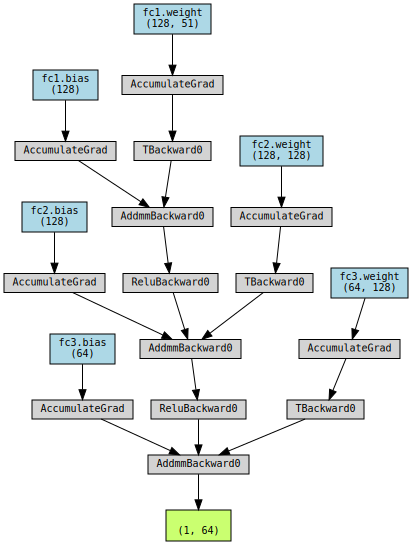

In [ ]:
from torchviz import make_dot

# Create an instance of the model
model = EmbeddingModel(input_size=51, embedding_size=64, hidden_size=128)

# Generate a dummy input
dummy_input = torch.randn(1, 51)  # Batch size 1, input size 10

# Visualize the model
make_dot(model(dummy_input), params=dict(model.named_parameters()))

# generate a model architecture visualization
# make_dot(model(dummy_input), params=dict(model.named_parameters()),
#          show_attrs=True,
#          show_saved=True).render("MyPyTorchModel_torchviz", format="png")

In [ ]:
# import torch

# def calculate_prototypes(support_set):
#     # Get unique class labels from the support set
#     unique_labels = torch.unique(support_set.targets)

#     prototypes = {}
#     for label in unique_labels:
#         # Select examples belonging to the current label
#         examples = support_set.data[support_set.targets == label]
#         # Calculate the mean feature vector for the current class
#         prototype = torch.mean(examples, dim=0)
#         # Store the prototype for the current class
#         prototypes[label.item()] = prototype

#     return prototypes

In [ ]:
# https://github.com/schatty/prototypical-networks-tf

# Model Building

In [ ]:
N_WAY = 5 # Number of classes in a task
N_SHOT = 5 # Number of images per class in the support set
N_QUERY = 1 # Number of images per class in the query set
N_EVALUATION_TASKS = 200

test_dataset.get_labels = lambda: [instance[1] for instance in test_dataset.samples]

test_sampler = TaskSampler(
    test_dataset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_dataset,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


created a dataloader that will feed us with 5-way 5-shot tasks (the most common setting in the litterature).

In [ ]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
example_class_ids

[0, 1, 2, 3, 4]

In [ ]:
len(example_query_labels)

5

In [ ]:
example_query_labels[0].item()

1

In [ ]:
example_class_ids[example_query_labels[0].item()]

1

In [ ]:
example_support_labels

tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3])

In [ ]:
test_dataset.classes[example_class_ids[example_query_labels[0].item()]]

'Cow'

For both support and query set, you should have one line for each class.


In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def evaluate_on_one_task(
    model,
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int, int, int]:
    """
    Returns the number of correct predictions of query labels, the total number of predictions,
    true positives (TP), and false negatives (FN).
    """
    # Extract the features of support and query images
    z_support = model.backbone.forward(support_images)
    z_query = model.backbone.forward(query_images)

    # Infer the number of different classes from the labels of the support set
    n_way = len(torch.unique(support_labels))
    # Prototype i is the mean of all instances of features corresponding to labels == i
    z_proto = torch.cat(
        [
            z_support[torch.nonzero(support_labels == label)].mean(0)
            for label in range(n_way)
        ]
    )

    # Get predictions for query images
    predictions = torch.max(
        model(z_proto, z_query)
        .detach()
        .data,
        1,
    )[1]

    # Calculate TP and FN
    TP = ((predictions == query_labels) & (predictions == 1)).sum().item()
    FN = ((predictions != query_labels) & (predictions == 0)).sum().item()

    return (
        (predictions == query_labels).sum().item(),  # correct predictions
        len(query_labels),  # total predictions
        TP,  # true positives
        FN,  # false negatives
    )


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0
    total_TP = 0
    total_FN = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total, TP, FN = evaluate_on_one_task(
                model, support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct
            total_TP += TP
            total_FN += FN

    accuracy = 100 * correct_predictions / total_predictions
    precision = total_TP / (total_TP + (total_predictions - correct_predictions))
    recall = total_TP / (total_TP + total_FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f"Model tested on {len(data_loader)} tasks.")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")


evaluate(test_loader)


100%|██████████| 200/200 [00:01<00:00, 187.37it/s]

Model tested on 200 tasks.
Accuracy: 72.10%
Precision: 0.33
Recall: 0.79
F1 Score: 0.47


With absolutely zero training, and only 5 examples per class, we achieve around 68.90% accuracy!


## Training a meta-learning algorithm


In [ ]:
N_TRAINING_EPISODES = 2000
N_VALIDATION_TASKS = 500

# train_set.labels = [instance[1] for instance in train_set._flat_character_images]   #incorrect, ignore this line; the following line is correct.
train_dataset.get_labels = lambda: [instance[1] for instance in train_dataset.samples]
visualize_dataset.get_labels = lambda: [instance[1] for instance in visualize_dataset.samples]

train_sampler = TaskSampler(
    train_dataset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)




Here we define our loss and our optimizer (cross entropy and Adam, pretty standard), and a `fit` method.
This method takes a classification task as input (support set and query set). It predicts the labels of the query set
based on the information from the support set; then it compares the predicted labels to ground truth query labels,
and this gives us a loss value. Then it uses this loss to update the parameters of the model. This is a *meta-training loop*.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:

    # Extract the features of support and query images
    z_support = model.backbone.forward(support_images)
    z_query = model.backbone.forward(query_images)

    # Infer the number of different classes from the labels of the support set
    n_way = len(torch.unique(support_labels))
    # Prototype i is the mean of all instances of features corresponding to labels == i
    z_proto = torch.cat(
        [
            z_support[torch.nonzero(support_labels == label)].mean(0)
            for label in range(n_way)
        ]
    )

    optimizer.zero_grad()
    classification_scores = model(z_proto,z_query)

    loss = criterion(classification_scores, query_labels)
    loss.backward()
    optimizer.step()

    return loss.item(), z_proto


To train the model, we are just going to iterate over a large number of randomly generated few-shot classification tasks,
and let the `fit` method update our model after each task. This is called **episodic training**.


In [ ]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value, z_proto = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))


100%|██████████| 2000/2000 [00:18<00:00, 109.57it/s, loss=0.174]


In [ ]:
evaluate(test_loader)

100%|██████████| 200/200 [00:01<00:00, 197.70it/s]

Model tested on 200 tasks.
Accuracy: 98.10%
Precision: 0.91
Recall: 1.00
F1 Score: 0.95


# Visualize prototypes

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
def visualize_embeddings(embeddings, labels, markers, title):
    # Apply t-SNE for dimensionality reduction to 2D
    tsne = TSNE(n_components=2, perplexity=4)
    embeddings_tsne = tsne.fit_transform(embeddings)

    # Set up the figure for plotting
    fig, ax = plt.subplots(figsize=(8, 8))

    # Set up the color map (one color per class)
    cmap = plt.cm.get_cmap('viridis', len(np.unique(labels)))

    # Create an empty list to store legend handles
    legend_handles = []

    # Iterate through the unique labels to create a legend handle for each class
    for label in np.unique(labels):
        legend_handles.append(
            plt.Line2D(
                [0],
                [0],
                marker='o',
                color=cmap(label),
                label=f'Class {label}',
                markerfacecolor=cmap(label),
                markersize=10,
                linestyle='None'
            )
        )

    # Add the legend for the classes
    ax.legend(handles=legend_handles, loc='upper left', title='Classes')

    for idx, (embedding, label, marker) in enumerate(zip(embeddings_tsne, labels, markers)):
        ax.scatter(*embedding, c=[cmap(label)], marker=marker, s=100)

    # Add a legend for the marker types
    support_marker = plt.Line2D([], [], color='k', marker='o', linestyle='None', markersize=10, label='Support Set')
    query_marker = plt.Line2D([], [], color='k', marker='*', linestyle='None', markersize=10, label='Query Set')
    prototype_marker = plt.Line2D([], [], color='k', marker='x', linestyle='None', markersize=10, label='Prototypes')

    # Adjust the alpha (transparency) of the prototype marker to make it more intense
    support_marker.set_alpha(0.2)
    query_marker.set_alpha(0.2)
    prototype_marker.set_alpha(1.0)

    ax.legend(handles=[support_marker, query_marker, prototype_marker], loc='upper right', title='Marker Types')

    # Configure plot appearance
    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    plt.show()

In [ ]:
visualize_sampler = TaskSampler(
    visualize_dataset, n_way=5, n_shot=10, n_query=5, n_tasks=10
)
visualize_loader = DataLoader(
    visualize_dataset,
    batch_sampler=visualize_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=visualize_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
tqdm_visualize = tqdm(enumerate(visualize_loader), total=len(visualize_loader))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 0/10 [01:46<?, ?it/s]


In [ ]:
(support_set, support_labels, query_set, query_labels,  _,) = next(iter(visualize_loader))

<ipython-input-74-4230d5246874>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  support_set = torch.tensor(support_set, dtype=torch.float32)
<ipython-input-74-4230d5246874>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_set = torch.tensor(query_set, dtype=torch.float32)
<ipython-input-74-4230d5246874>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  support_labels = torch.tensor(support_labels, dtype=torch.long)
<ipython-input-51-e47e7bea1744>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.

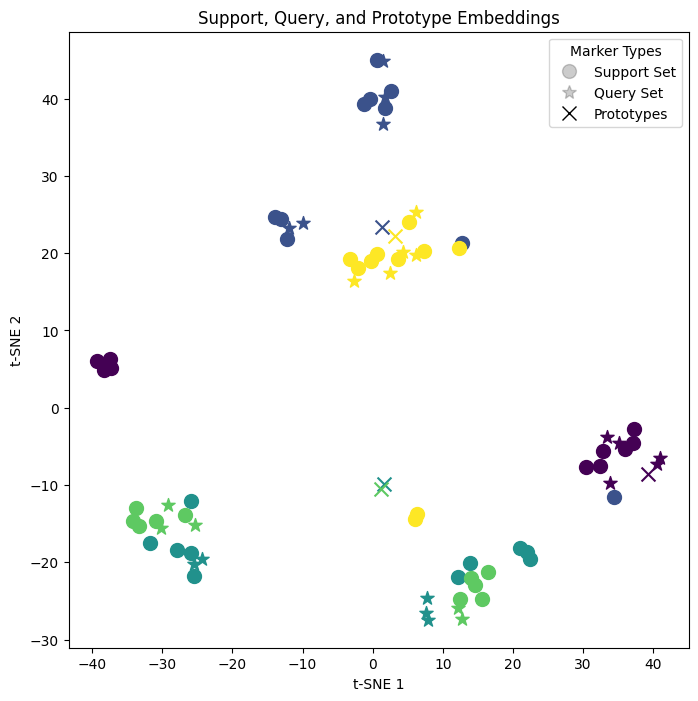

In [ ]:
support_set = torch.tensor(support_set, dtype=torch.float32)
query_set = torch.tensor(query_set, dtype=torch.float32)
support_labels = torch.tensor(support_labels, dtype=torch.long)

# Extract embeddings and labels for support set, query set, and prototypes
support_embeddings = model.backbone(support_set)
query_embeddings = model.backbone(query_set)

z_proto = torch.cat(
            [
                support_embeddings[torch.nonzero(support_labels == label)].mean(0)
                for label in range(N_WAY)
            ]
        )
# print ("z_proto", z_proto)
prototype_embeddings = z_proto.detach().numpy()

# Create markers for support set ('o'), query set ('*'), and prototypes ('x')
support_markers = ['o'] * len(support_labels)
query_markers = ['*'] * len(query_labels)
prototype_markers = ['x'] * len(np.unique(support_labels))

# Concatenate support, query, and prototype data
all_embeddings = np.concatenate([support_embeddings.detach().numpy(), query_embeddings.detach().numpy(), prototype_embeddings], axis=0)
all_labels = np.concatenate([support_labels, query_labels, np.unique(support_labels)], axis=0)
all_markers = support_markers + query_markers + prototype_markers

# Visualize the embeddings
visualize_embeddings(all_embeddings, all_labels, all_markers, "Support, Query, and Prototype Embeddings")

# Stats Generation

for 64 hidden layers and 32 embedding size:
5-way 5-shot learning

*   accuracy - 94.68%

for 128 hidden layers and 64 embedding size:
5-way 5-shot learning

*   accuracy - 97.52%

for 256 hidden layers and 128 embedding size:
5-way 5-shot learning

*   accuracy - 68.08%



In [ ]:
# Data for 128 hidden and 64 embeddings
training_episodes = [1000, 2000, 3000, 4000, 5000,6000, 7000, 8000, 9000, 10000]
five_way_five_shot = [96.64, 97.68, 97.08, 96.64, 97.52, 95.88, 97.2, 96.0, 97.40, 96.40]
five_way_one_shot = [83.84, 92.40, 94.96, 92.80, 95.68, 94.68, 93.80, 94.20, 94.20, 91.92]

# Plot
plt.figure(figsize=(10, 6))

# 5-way 5-shot learning
plt.plot(training_episodes, five_way_five_shot, marker='o', label='5-way 5-shot')

# 5-way 1-shot learning
plt.plot(training_episodes, five_way_one_shot, marker='o', label='5-way 1-shot')

# Add labels and title
plt.title('Accuracy vs Training Episodes')
plt.xlabel('Training Episodes')
plt.ylabel('Accuracy (%)')

# Add legend
plt.legend()

# Show grid
plt.grid(True)

# Show plot
plt.show()

In [ ]:
# Data for 64 hidden and 32 embeddings
training_episodes = [1000, 2000, 3000, 4000, 5000,6000, 7000, 8000, 9000, 10000]
five_way_five_shot_64_32 = [68.76, 68.12, 67.48, 70.92, 67.84, 69.00, 69.68, 67.88, 69.72, 67.72]
five_way_five_shot_128_64 = [96.64, 97.68, 97.08, 96.64, 97.52, 95.88, 97.2, 96.0, 97.40, 96.40]
five_way_five_shot_256_128 = [67.32, 67.20, 66.52, 67.12, 68.08, 66.96, 68.68, 66.88, 66.24, 68.28]
# five_way_one_shot = [86.7, 89.7, 95.6, 91.4, 94.9, 95.4, 95.5, 94.5, 95.5, 94.1]

# Plot
plt.figure(figsize=(10, 6))

# five_way_five_shot_64_32
plt.plot(training_episodes, five_way_five_shot_64_32, marker='o', label='five_way_five_shot_64_32')

# five_way_five_shot_128_64
plt.plot(training_episodes, five_way_five_shot_128_64, marker='o', label='five_way_five_shot_128_64')

# five_way_five_shot_256_128
plt.plot(training_episodes, five_way_five_shot_256_128, marker='o', label='five_way_five_shot_256_128')

# Add labels and title
plt.title('Accuracy vs Training Episodes')
plt.xlabel('Training Episodes')
plt.ylabel('Accuracy (%)')

# Add legend
plt.legend()

# Show grid
plt.grid(True)

# Show plot
plt.show()

In [ ]:
# Data for 256 hidden and 128 embeddings
training_episodes = [1000, 2000, 3000, 4000, 5000,6000, 7000, 8000, 9000, 10000]
five_way_five_shot = [67.32, 67.20, 66.52, 67.12, 68.08, 66.96, 68.68, 66.88, 66.24, 68.28]
# five_way_one_shot = [86.7, 89.7, 95.6, 91.4, 94.9, 95.4, 95.5, 94.5, 95.5, 94.1]

**Results**
for 5000 training episodes and 500 test tasks:


1.   5-way 5-shot learning


*   accuracy: 94.68%


2.   5-way 1-shot learning


*   accuracy: 92.90%

for 4000 training episodes:


1.   5-way 5-shot learning


*   accuracy: 97.80


2.   5-way 1-shot learning


*   accuracy: 92.00%


for 2000 training episodes:


1.   5-way 5-shot learning


*   accuracy: 94.10


2.   5-way 1-shot learning


*   accuracy: 89.70%

for 1000 training episodes:


1.   5-way 5-shot learning


*   accuracy: 89.90%


2.   5-way 1-shot learning


*   accuracy: 86.70%











In [ ]:
# Data
training_episodes = [1000, 2000, 3000, 4000, 5000,6000, 7000, 8000, 9000, 10000]
five_way_five_shot = [89.9, 94.1, 97.1, 98.0, 98.7, 97.0, 98.1, 97.3, 97.2, 97.3]
five_way_one_shot = [86.7, 89.7, 95.6, 91.4, 94.9, 95.4, 95.5, 94.5, 95.5, 94.1]

# Plot
plt.figure(figsize=(10, 6))

# 5-way 5-shot learning
plt.plot(training_episodes, five_way_five_shot, marker='o', label='5-way 5-shot')

# 5-way 1-shot learning
plt.plot(training_episodes, five_way_one_shot, marker='o', label='5-way 1-shot')

# Add labels and title
plt.title('Accuracy vs Training Episodes')
plt.xlabel('Training Episodes')
plt.ylabel('Accuracy (%)')

# Add legend
plt.legend()

# Show grid
plt.grid(True)

# Show plot
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

def evaluate_with_confusion_matrix(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0
    all_true_labels = []
    all_predicted_labels = []

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            # Extract the features of support and query images
            z_support = model.backbone.forward(support_images)
            z_query = model.backbone.forward(query_images)
            # print(z_query)

            # Infer the number of different classes from the labels of the support set
            n_way = len(torch.unique(support_labels))
            # Prototype i is the mean of all instances of features corresponding to labels == i
            z_proto = torch.cat(
                [
                    z_support[torch.nonzero(support_labels == label)].mean(0)
                    for label in range(n_way)
                ]
            )
            predicted_labels = torch.max(
                model(z_proto, z_query)
                .detach()
                .data,
                1,
            )[1]

            correct_predictions += (predicted_labels == query_labels).sum().item()
            total_predictions += len(predicted_labels)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(conf_matrix)
    return conf_matrix

conf_matrix = evaluate_with_confusion_matrix(test_loader)


In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
# Set global font size for the plot
plt.rcParams.update({'font.size': 20})
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 20})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
labels = ['Bow', 'Cow', 'Extended Hand to Toe', 'Side Plank', 'Wheel']
def load_label_images():
    # Define a dictionary to store label images
    label_images = {}

    # Load and preprocess images for each label
    # Replace this with your own code to load label images
    # Example:
    for label in range(5):
        img_path = f"label_{label}.jpg"  # Replace with actual image paths
        img = plt.imread(img_path)
        label_images[label] = img

    return label_images

# Save Model and Load Model

In [ ]:
model_path = "/content/drive/MyDrive/FYP Works Pvt/CustomYogaPosesDatasetKeypoints/models"

In [ ]:
model_path = "/content/drive/MyDrive/FYP Works Pvt/CustomYogaPosesDatasetKeypoints/models"
# Save the model state dictionary
torch.save(model.state_dict(), f'{model_path}/pn_keypoints_model_new_archi_state_dict_.pth')


In [ ]:
# Create an instance of the model
backbone = EmbeddingModel(51, 64, 128)
loaded_model = PrototypicalNetworks(backbone)

# Load the saved state dictionary
loaded_model.load_state_dict(torch.load(f'{model_path}/pn_keypoints_model_new_archi_state_dict_.pth'))

# Set the model to evaluation mode
loaded_model.eval()


In [ ]:
input_data = [0.29048792,0.5101282,0.7621804,0.2792785,0.52290124,0.6813526,0.27649108,0.49520573,0.7068986,0.2866955,0.5408184,0.860243,0.284765,0.48234257,0.6723526,0.34830886,0.5613633,0.7201387,0.34979814,0.45341593,0.63936824,0.45908514,0.5929659,0.6139707,0.46461016,0.4310734,0.64750683,0.39385217,0.5248979,0.629963,0.39068535,0.48147148,0.42890516,0.5108007,0.52939993,0.81060743,0.5110426,0.46251974,0.75979775,0.6813238,0.52148306,0.7446966,0.57723504,0.33532208,0.7357522,0.83112574,0.5045755,0.59225297,0.61695933,0.46835133,0.4566399]

In [ ]:
z_proto

In [ ]:
input_tensor = torch.tensor(input_data, dtype=torch.float32)

In [ ]:
z_input = loaded_model.backbone.forward(input_tensor)

In [ ]:
z_proto_values = [
    [ 3.8862,  4.4147, -2.4238, -2.2466, -0.7154,  5.6670,  1.9135,  4.8023,
         -2.5509,  7.9634,  1.3133,  6.6616, -0.3204,  0.4031,  4.2944,  2.7816,
         -2.7976, -2.3817,  4.3091, -0.7914,  2.8942,  0.4218,  8.2378,  3.6200,
          4.2746, -5.9138, -3.8093,  3.4939, -1.4226,  1.5245,  4.3281,  4.9287,
          2.2486,  3.1771, -7.0235,  2.5687,  6.3001,  0.7247, -1.8060, -1.9594,
          3.8162,  2.1278,  2.4651,  0.6176, -2.0660,  0.5139,  0.4979, -0.9674,
          5.1807,  5.3713,  4.7676, -1.6827, -6.9286,  0.9802,  6.1986,  4.1552,
          3.8625, -1.6805,  3.0438, -6.4240, -2.0364, -2.8750,  3.8305, -2.5993],
        [ 3.5332,  0.5192,  0.4848,  1.1259, -3.2625,  2.3357, -0.5856,  6.1022,
         -0.1979,  3.0924,  3.4229,  7.2437, -1.1678,  3.0504,  0.6109, -0.1495,
         -4.7388,  1.1632,  1.1080, -2.8280, -1.0302,  2.1995,  4.3462, -0.2651,
          0.9180, -4.8121, -0.0496,  3.7678, -2.5704,  3.7839,  4.9119,  2.0025,
         -1.2584, -0.5591, -3.0930, -1.3748,  1.8319,  2.8514, -3.4035,  1.4160,
          0.2154,  0.5914,  4.4888,  2.5246, -3.0090, -2.7665, -2.3873, -2.7614,
          2.7878,  5.5467,  6.0725, -3.8706, -6.8077, -1.3530,  1.3037,  4.9392,
          1.7263, -3.4445,  5.4894, -2.2541, -1.9819,  0.5823,  2.6416,  0.4939],
        [ 2.0677,  3.9941, -2.8559, -2.2862, -0.3578,  4.0094,  3.2410,  4.0625,
         -3.9430,  6.7867,  0.8374,  5.8225,  1.4483,  0.9109,  4.1992,  1.8612,
         -1.9878, -1.9019,  3.2610, -1.5295,  3.0135, -1.2675,  7.9838,  4.0338,
          4.2438, -3.9083, -3.2193,  1.7253,  0.4397,  1.0045,  2.5589,  3.1168,
          2.4561,  2.6079, -5.4628,  2.5108,  5.0665,  1.6160, -0.7036, -1.2268,
          2.9387,  0.2463,  1.4251, -0.5615, -0.6808,  0.2524,  1.1808, -0.4616,
          3.1112,  3.9824,  3.5392, -0.8937, -5.3472,  2.1035,  5.6968,  2.6714,
          1.9619, -0.3995,  2.3840, -5.1832,  0.0392, -3.3435,  1.9068, -2.4145],
        [ 2.9149,  4.7311, -3.2614, -2.4277, -0.9146,  5.2228,  3.6640,  5.4963,
         -4.6905,  8.6220,  1.4194,  7.7529,  1.4425,  1.3529,  5.0263,  2.2328,
         -2.9468, -2.2423,  4.1433, -2.0292,  3.6874, -1.1020, 10.1355,  4.7409,
          5.2309, -5.3820, -3.8226,  2.6678,  0.1304,  1.8912,  3.6945,  4.1712,
          2.8307,  3.1608, -7.0495,  2.9685,  6.4523,  2.1261, -1.2730, -1.3779,
          3.7422,  0.6396,  2.2530, -0.2472, -1.3632,  0.1716,  1.0198, -0.9571,
          4.3512,  5.5277,  4.9745, -1.5077, -7.3623,  2.3686,  7.1210,  3.8908,
          2.9357, -0.9807,  3.5420, -6.7523, -0.3296, -4.0211,  2.7979, -2.9746],
        [ 1.0853,  3.4126, -2.7329, -2.0279, -0.3258,  2.9560,  3.4894,  3.5680,
         -4.1761,  5.7294,  0.6100,  5.1125,  1.9526,  1.1338,  3.7592,  1.2874,
         -1.6064, -1.3631,  2.5416, -1.7777,  2.7070, -1.8363,  7.2793,  3.8307,
          3.8727, -2.8353, -2.6447,  0.9067,  1.1421,  0.8550,  1.7381,  2.0525,
          2.1709,  2.0817, -4.3625,  2.1915,  4.1680,  1.8263, -0.2366, -0.7667,
          2.2879, -0.5621,  0.9798, -0.8742, -0.1291, -0.0234,  1.2407, -0.2622,
          2.0074,  3.2052,  2.8624, -0.6079, -4.3849,  2.3168,  4.9214,  1.9441,
          1.0637,  0.0612,  2.0895, -4.2433,  0.8623, -3.2138,  0.9567, -2.0102]
]

z_proto = torch.tensor(z_proto_values)

In [ ]:
z_proto = z_proto.unsqueeze(0) if z_proto.dim() == 1 else z_proto
input_tensor = input_tensor.unsqueeze(0) if input_tensor.dim() == 1 else input_tensor
z_input = loaded_model.backbone.forward(input_tensor)

In [ ]:
loaded_model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient tracking during inference
    # Reshape z_proto and input_tensor to have at least 2 dimensions
    z_proto = z_proto.unsqueeze(0) if z_proto.dim() == 1 else z_proto
    input_tensor = input_tensor.unsqueeze(0) if input_tensor.dim() == 1 else input_tensor
    z_input = loaded_model.backbone.forward(input_tensor)

    output = loaded_model(z_proto, z_input)

# Interpret the model's output
# For example, if your model is for classification, you might want to find the predicted class
predicted_class = torch.argmax(output, dim=1).item()

# You can print or use the predicted class as per your requirement
print("Predicted Class:", predicted_class)

# Convert to tflite

In [ ]:
!pip install onnx-tf

In [ ]:
import torch.onnx
import onnx
from onnx_tf.backend import prepare

# Assuming you have your trained PyTorch model saved as 'trained_model.pth'
# Load the trained PyTorch model
# trained_model = PrototypicalNetworks(EmbeddingModel(input_size, embedding_size, hidden_size))
# trained_model.load_state_dict(torch.load('trained_model.pth'))
# trained_model.eval()

# Convert the PyTorch model to ONNX
dummy_input = (z_proto, z_input)
output_onnx = 'trained_model.onnx'
torch.onnx.export(loaded_model, dummy_input, output_onnx, export_params=True, opset_version=11)

# Load the ONNX model
onnx_model = onnx.load(output_onnx)

# Convert the ONNX model to TensorFlow Lite
tf_rep = prepare(onnx_model)
tflite_model = tf_rep.export()

# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
# Assuming z_proto and input_tensor are numpy arrays or PyTorch tensors
print("Shape of z_proto:", z_proto.shape)
print("Shape of input_tensor:", z_input.shape)


In [ ]:
import torch.onnx
import tensorflow as tf
import onnx
# from onnx_tf.backend import prepare

# Convert PyTorch model to ONNX format
torch.onnx.export(loaded_model,  # PyTorch model
                  (z_proto, z_input),  # Sample input (tuple of input tensors)
                  "model.onnx",  # Path to save the ONNX model
                  input_names=["z_proto", "z_input"],  # Input names
                  output_names=["output"],  # Output names
                  )



In [ ]:

                  # export_params=True,  # Export model parameters
                  # opset_version=12,  # ONNX opset version
                  # do_constant_folding=True,  # Fold constant operations
                  # dynamic_axes={"z_proto": {0: "batch_size"},  # Dynamic axes for input tensor z_proto
                  #               "input_tensor": {0: "batch_size"},  # Dynamic axes for input tensor input_tensor
                  #               "output": {0: "batch_size"}} # Dynamic axes for output tensor output

In [ ]:

# Load the ONNX model
onnx_model = onnx.load("model.onnx")

# Prepare the ONNX model for TensorFlow
tf_rep = prepare(onnx_model)



In [ ]:
# # Export the TensorFlow model
tf_model_path = "model.tf"
tf_rep.export_graph(tf_model_path)

In [ ]:
# Load the TensorFlow model
tf_model = tf.saved_model.load(tf_model_path)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("model.tf")
tflite_model = converter.convert()
open('model_new_prot.tflite', 'wb').write(tflite_model)

In [ ]:
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="model_new_prot.tflite")
interpreter.allocate_tensors()


In [ ]:
import numpy as np

# Assuming your input_data is already defined
input_data = np.array(input_data, dtype=np.float32)
input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension if necessary


In [ ]:
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])


# **break**

In [ ]:
# Load the TensorFlow model
tf_model = tf.saved_model.load(tf_model_path)

# Define a concrete function for the TensorFlow model
concrete_func = tf_model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

# Create input and output tensors with the desired shapes
# Assuming `z_proto` and `input_tensor` are numpy arrays
z_proto_tensor = tf.constant(z_proto, dtype=tf.float32)
input_tensor_tensor = tf.constant(input_tensor, dtype=tf.float32)

# Set the shapes of the input tensors
z_proto_tensor.set_shape([5, 32])  # Set the shape of z_proto to [5, 32]
input_tensor_tensor.set_shape([1, 32])  # Set the shape of input_tensor to [1, 32]

# Run inference on the concrete function to infer the output tensor shape
output = concrete_func(z_proto=z_proto_tensor, input_tensor=input_tensor_tensor)

# Convert TensorFlow model to TensorFlow Lite (TFLite)
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

# Save the TFLite model to a file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)


In [ ]:
z_proto

In [ ]:
z_input

In [ ]:
import numpy as np
import tensorflow as tf

# Sample input data
input_data = [0.29048792, 0.5101282, 0.7621804, 0.2792785, 0.52290124, 0.6813526, 0.27649108, 0.49520573, 0.7068986, 0.2866955, 0.5408184, 0.860243, 0.284765, 0.48234257, 0.6723526, 0.34830886, 0.5613633, 0.7201387, 0.34979814, 0.45341593, 0.63936824, 0.45908514, 0.5929659, 0.6139707, 0.46461016, 0.4310734, 0.64750683, 0.39385217, 0.5248979, 0.629963, 0.39068535, 0.48147148, 0.42890516, 0.5108007, 0.52939993, 0.81060743, 0.5110426, 0.46251974, 0.75979775, 0.6813238, 0.52148306, 0.7446966, 0.57723504, 0.33532208, 0.7357522, 0.83112574, 0.5045755, 0.59225297, 0.61695933, 0.46835133, 0.4566399]

# Convert input data to numpy array
input_data_np = np.array(input_data, dtype=np.float32)

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Check the input shape and type required by the model
input_shape = input_details[0]['shape']
input_dtype = input_details[0]['dtype']

# Check the output shape and type produced by the model
output_shape = output_details[0]['shape']
output_dtype = output_details[0]['dtype']

# Ensure the input data matches the required shape and type
assert input_data_np.shape == input_shape[1:], "Input data shape mismatch"
assert input_dtype == np.float32, "Input data type mismatch"

# Set the input tensor to the input data
interpreter.set_tensor(input_details[0]['index'], input_data_np.reshape(input_shape))

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Display the output
print("Output:", output_data)


In [ ]:
import numpy as np
import tensorflow as tf

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input data
z_proto = np.random.randn(5, 32)  # Example z_proto data with shape [5, 32]
input_tensor = np.random.randn(1, 32)  # Example input_tensor data with shape [1, 32]

# Convert input tensor values to float32
z_proto = z_proto.astype(np.float32)
input_tensor = input_tensor.astype(np.float32)

# Set input tensor values
interpreter.set_tensor(input_details[0]['index'], z_proto)
interpreter.set_tensor(input_details[1]['index'], input_tensor)


# Run inference
interpreter.invoke()

# Get output tensor values
output = interpreter.get_tensor(output_details[0]['index'])

# Interpret the model's output
predicted_class = np.argmax(output, axis=1)

# You can print or use the predicted class as per your requirement
print("Predicted Class:", predicted_class)


In [ ]:
model_path = "/content/drive/MyDrive/FYP Works Pvt/CustomYogaPosesDatasetKeypoints/models"
# Save the entire model
torch.save(model, f'{model_path}/pn_keypoints_model_v1_.pth')

# OR save the model's state dictionary
torch.save(model.state_dict(), f'{model_path}/pn_keypoints_model_state_dict_v1.pth')

In [ ]:
import torch

# Load the entire model
model = torch.load("/content/drive/MyDrive/FYP Works Pvt/CustomYogaPosesDatasetKeypoints/models/pn_keypoints_model_v1_.pth")


In [ ]:
# model.predict([314.27594,571.07794,0.1944652,309.28357,561.0856,0.3147477,311.44452,568.3765,0.2785584,316.07465,584.76166,0.16580762,346.14212,594.17444,0.1524918,343.55292,623.2222,0.14873004,386.9048,593.989,0.09332667,289.80103,576.4622,0.018134575,349.4297,578.49744,0.022398164,307.5594,603.83325,0.030104598,351.45673,601.5659,0.04818404,345.6313,570.7922,0.016430767,404.30115,563.7467,0.015815526,279.5294,531.1466,0.023643173,348.44937,515.6365,0.011559398,289.31656,578.6769,0.00978298,380.419,628.71466,0.09024537])

# Another approach to convert to tf

In [ ]:
!pip3 install pytorch2keras

In [ ]:
# import transferring tool
from pytorch2keras.converter import pytorch_to_keras

def converted_fully_convolutional_resnet18(
    input_tensor, pretrained_resnet=True,
):
    # define input tensor
    input_var = Variable(torch.FloatTensor(input_tensor))

    # get PyTorch ResNet18 model
    model_to_transfer = FullyConvolutionalResnet18(pretrained=pretrained_resnet)
    model_to_transfer.eval()

    # convert PyTorch model to Keras
    model = pytorch_to_keras(
        model_to_transfer,
        input_var,
        [input_var.shape[-3:]],
        change_ordering=True,
        verbose=False,
        name_policy="keep",
    )

    return model